# Experimentos - regresión

## 1. Carga de datos

In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np

from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv

In [2]:
from torch_geometric_temporal.nn.recurrent import GCLSTM

from torch_geometric_temporal.dataset import EnglandCovidDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split
from utils.dynamic_graph_temporal_signal import DynamicGraphTemporalSignalLen
from utils import powergrid


In [3]:
def format_plot(ax):
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')

    ax.xaxis.label.set_color('dimgrey')
    ax.tick_params(axis='both', colors='dimgrey', size=12, pad=1)

In [4]:
folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"


In [8]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="regression")
_,_,_=loader.process()

Processing:  row_214
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_32
Processing:  row_57
Processing:  row_110
Processing:  row_248
Processing:  row_119
Processing: 

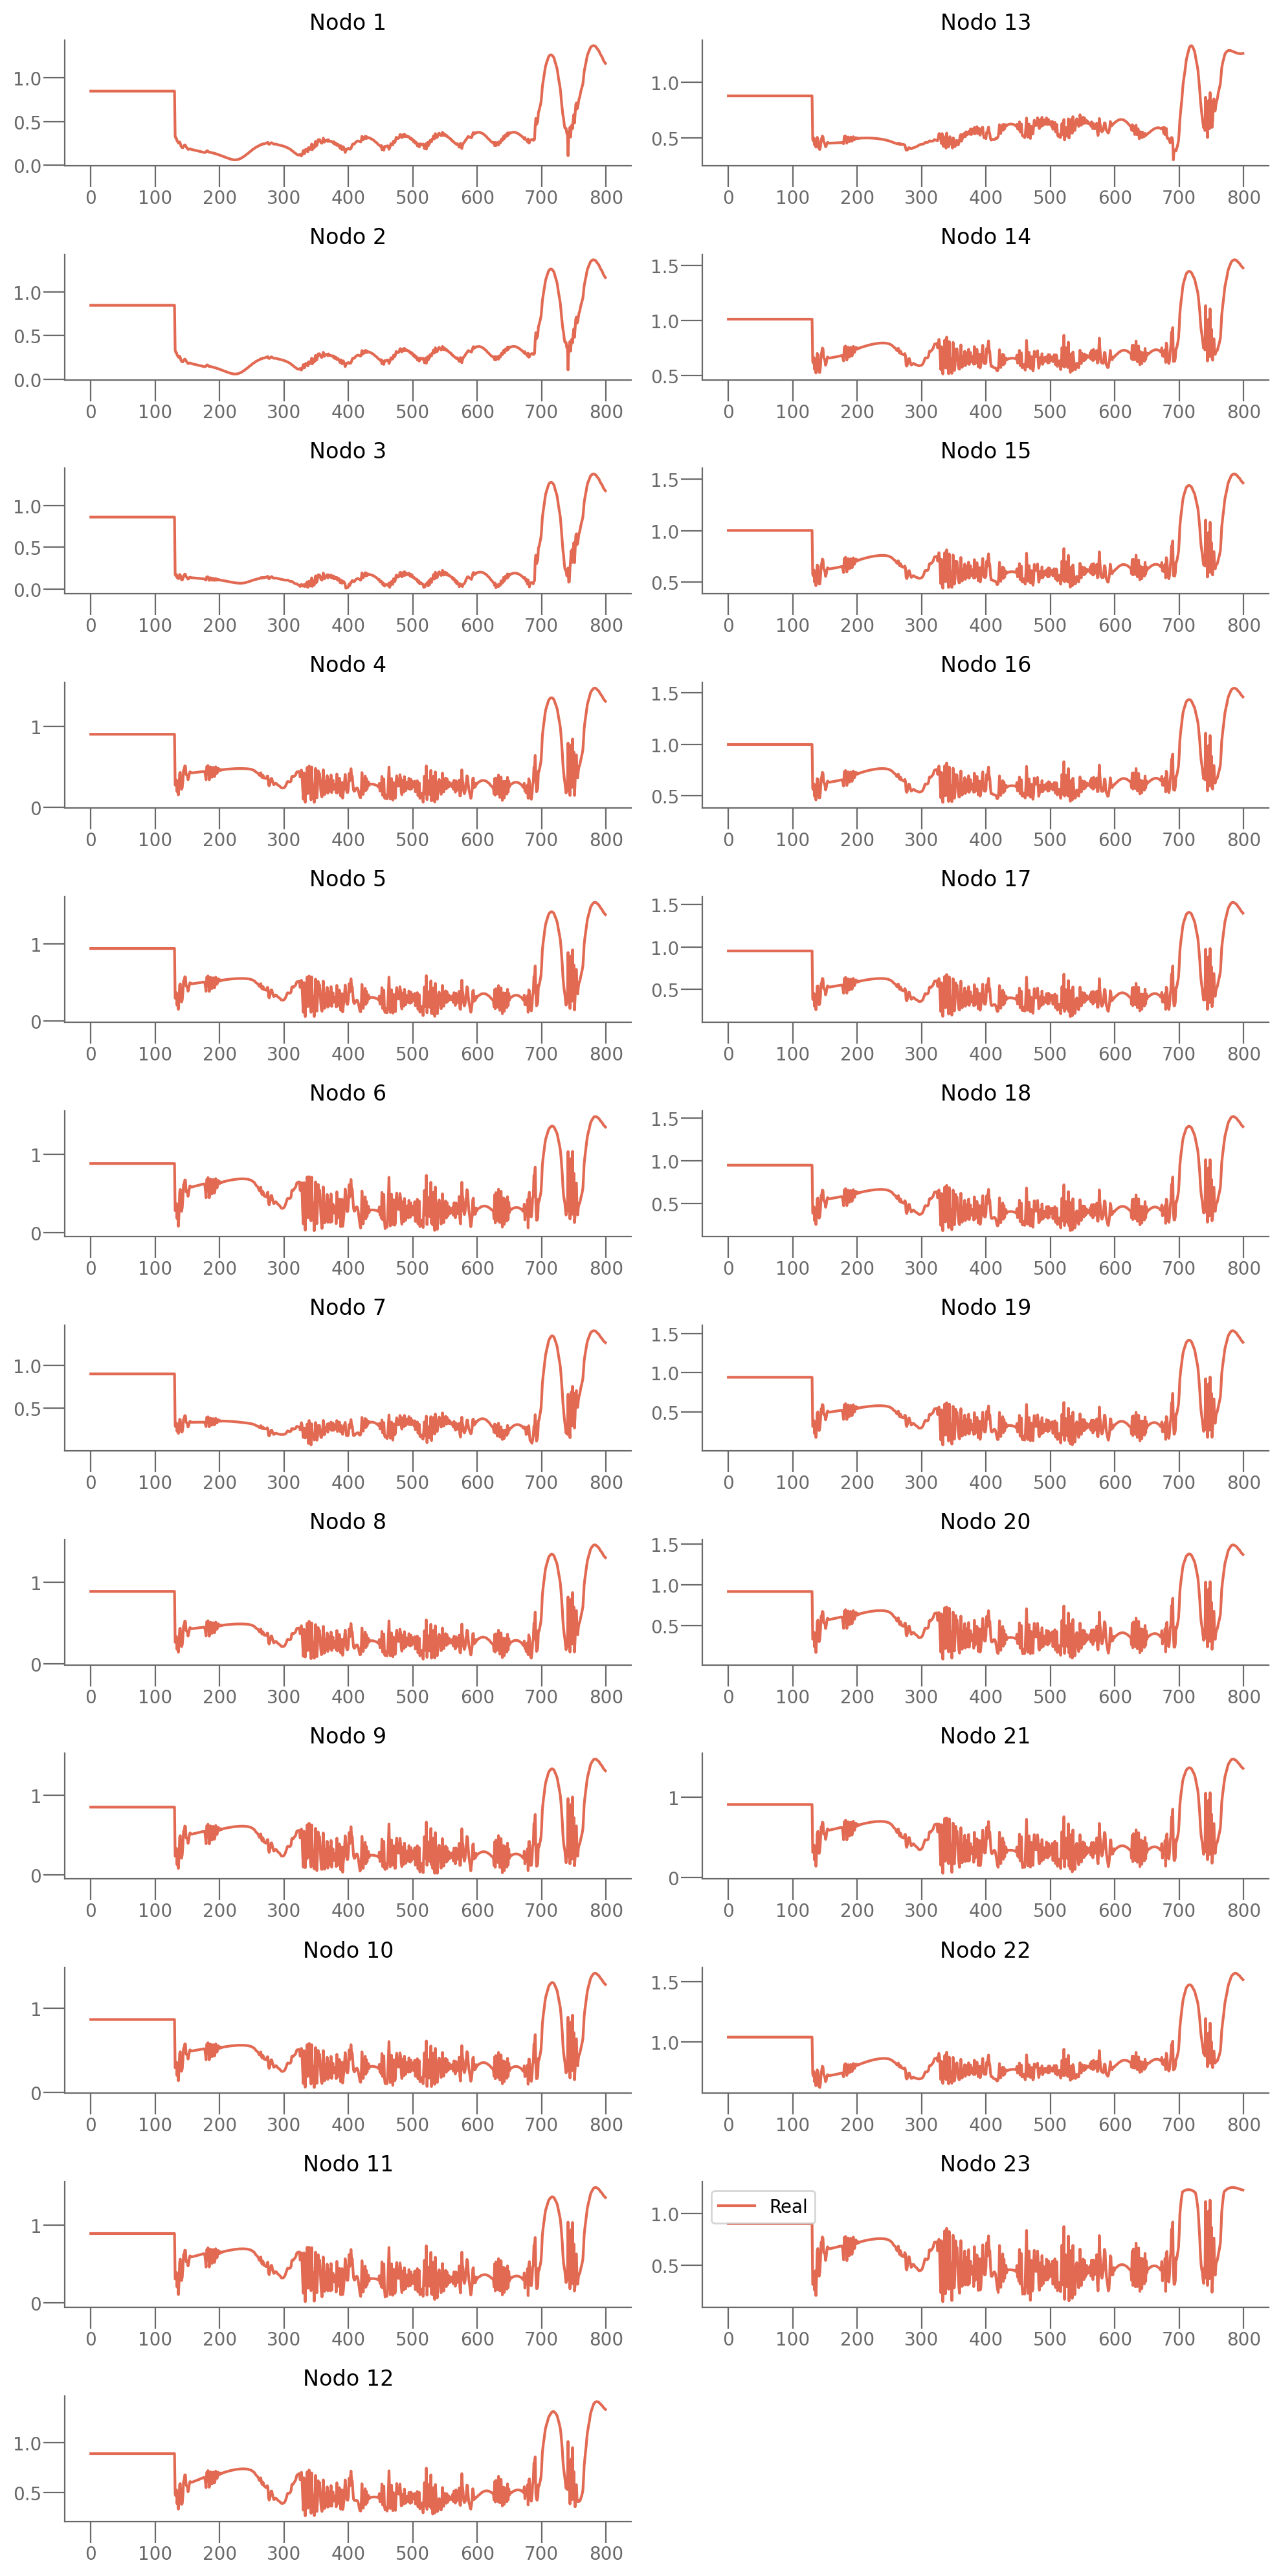

In [9]:
info_nodos = loader.reconstruir_voltages(1)


n_plots = 23
n_cols = 2
n_rows = (n_plots + 1) // 2  # División redondeada hacia arriba

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 20),dpi=200)
# Trazar los gráficos
for i in range(n_plots):
    row = i % n_rows  # Calculamos el índice de la fila
    col = i // n_rows  # Calculamos el índice de la columna
    ax = axs[row, col] if n_plots > 1 else axs
    
    ax = axs[row, col] if n_plots > 1 else axs
    
    sns.lineplot(y=info_nodos[i],x=range(len(info_nodos[i])), ax=ax, label='Real', legend=False)
        
    ax.set_title(f'Nodo {i+1}')
    format_plot(ax)
    # Añadir leyenda solo al último plot
    if i == n_plots - 1:
        ax.legend(loc='upper left')

if n_plots % n_cols != 0:
    fig.delaxes(axs.flatten()[-1])
# Ajustes finales
plt.tight_layout()
plt.show()

## 2. Experimentos 


### Funciones auxiliares


In [11]:
from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import AGCRN
from sklearn.metrics import r2_score

from torch.optim.lr_scheduler import ReduceLROnPlateau


from utils.trainer import TrainerModel
from utils import trainer
dtype = torch.float
device = torch.device("cpu")

In [12]:
def reconstruir_predictions(predictions,real, n_target, situacion, n_div, n_nodes=23):
    
    temp = np.array(predictions).reshape(-1, n_nodes, n_target)
    temp2 =np.array(real).reshape(-1, n_nodes, n_target)
    if n_div != None:
        id_situacion = situacion*n_div 
        return n_div, np.concatenate([np.array(temp[id_situacion+i]) for i in range(n_div)], axis=1), np.concatenate([np.array(temp2[id_situacion+i]) for i in range(n_div)], axis=1)
    m = temp.shape[0]
    return m, np.concatenate([np.array(temp[situacion+i]) for i in range(m)], axis=1), np.concatenate([np.array(temp2[situacion+i]) for i in range(m)], axis=1)


In [13]:
def plot_training_and_eval_losses(train_losses, eval_losses, num_epochs, format_plot):
    epochs = range(1, num_epochs + 1)


    plt.figure(figsize=(12, 5), dpi=200)
    ax = plt.gca()

    sns.lineplot(x=epochs, y=train_losses, label='Training Loss')
    sns.lineplot(x=epochs, y=eval_losses, label='Evaluation Loss', color="royalblue")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Loss by Epoch')
    ax.legend()
    format_plot(ax) 
    plt.tight_layout()
    plt.show()

In [14]:
def plot_predictions(predictions, real, n_target, n_situation, n_div=None):
    
    m, preds, y_true = reconstruir_predictions(predictions,real, n_target, n_situation, n_div=n_div)
    n_plots = 23
    n_cols = 2
    n_rows = (n_plots + 1) // 2  # División redondeada hacia arriba

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 20),dpi=200)
    # Trazar los gráficos
    for i in range(n_plots):
        row = i % n_rows  # Calculamos el índice de la fila
        col = i // n_rows  # Calculamos el índice de la columna
        ax = axs[row, col] if n_plots > 1 else axs
        
        ax = axs[row, col] if n_plots > 1 else axs
        
        sns.lineplot(y=y_true[i],x=range(n_target*m), ax=ax, label='Real', legend=False, color="royalblue")
        

        sns.lineplot(y=preds[i],x=range(n_target*m),ax=ax, label='Predicciones', legend=False)
        
        ax.set_title(f'Nodo {i+1}')
        format_plot(ax)
        # Añadir leyenda solo al último plot
        if i == n_plots - 1:
            ax.legend(loc='upper left')

    if n_plots % n_cols != 0:
        fig.delaxes(axs.flatten()[-1])
    # Ajustes finales
    plt.tight_layout()
    plt.show()

In [17]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, n_features, n_nodes, embedding_dim, name, n_target):
        self.name  =name
        self.n_nodes = n_nodes
        self.n_target = n_target
        self.embedding_dim =embedding_dim
        self.n_features = n_features
        super(RecurrentGCN, self).__init__()

        self.recurrent = AGCRN(number_of_nodes = n_nodes,
                              in_channels = n_features,
                              out_channels = n_nodes,
                              K = 2,
                              embedding_dimensions = embedding_dim)
        self.linear = torch.nn.Linear(n_nodes,n_target)



    def forward(self, x, e, h):
        h_0 = self.recurrent(x, e, h)
        y = F.relu(h_0)
        y = self.linear(y)
        return y, h_0


In [35]:
def eval(model, dataloader, e, h):
    model.eval()
    e_loss_batch, r2_loss_batch = [], []
    
    for batch in dataloader['val']:
        batch = batch.to(device)
        x = batch.x.view(len(batch), model.n_nodes, model.n_features)
        y_hat, h = model(x, e, h)
        loss = F.mse_loss(y_hat.view(-1, model.n_target), batch.y).item()
        r2_loss_batch.append(r2_score(batch.y.cpu(), y_hat.view(-1, model.n_target).cpu()))
        e_loss_batch.append(loss)
    return e_loss_batch, r2_loss_batch



def train(model,dataloader, num_early_stop, num_epochs, lr ):

    print("\n==================== TRAIN INFO ===================\n")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    lr_schedule = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, min_lr=0.001)
    early_stop_counter = 0
    best_eval_r2score = -100.0
    best_eval_loss = float('inf')
    losses = []
    eval_losses, r2scores = [], []
    is_best = False

    e = torch.empty(model.n_nodes, model.embedding_dim)
    torch.nn.init.xavier_uniform_(e)
    i = 0

    for epoch in range(num_epochs):
        h = None
        losses_batch = []
        model.train()
        
        for batch in dataloader['train']:
            x = batch.x.view(len(batch), model.n_nodes, model.n_features)
            y_hat, h = model(x, e, h)
            loss = F.mse_loss(y_hat.view(-1, model.n_target), batch.y)
            loss.backward(retain_graph=False)
            loss = loss.detach()
            h = h.detach()
            losses_batch.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()
            i += 1
            
        train_loss = torch.FloatTensor(losses_batch).mean().item()
        losses.append(losses_batch)
    
        with torch.no_grad():
            e_loss_batch, r2_loss_batch = eval(model, dataloader, e, h)
            eval_loss = torch.FloatTensor(e_loss_batch).mean().item()
            eval_r2score = torch.FloatTensor(r2_loss_batch).mean().item()
            eval_losses.append(e_loss_batch)
            r2scores.append(r2_loss_batch)
        
        print(f"Epoch {epoch + 1}/{num_epochs} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Eval Loss: {eval_loss:.4f} | "
            f"Eval R2: {eval_r2score:.4f} | "
            f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        if num_early_stop > 0:
            if eval_loss <= best_eval_loss:
                best_eval_loss = eval_loss
                early_stop_counter = 0
            else:
                early_stop_counter += 1
            if epoch > num_epochs / 2 and early_stop_counter > num_early_stop:
                print("Early stopping triggered.")
                break
            
        if lr_schedule:
            lr_schedule.step(eval_loss)

        if best_eval_r2score < eval_r2score:
            is_best = True
            best_eval_r2score = eval_r2score
        recording = {"epoch": epoch, "is_best": str(is_best)}
    return losses, eval_losses, r2scores, e, h
    print("\nTraining completed.")


def test(model, dataloader, e, h):
    
    print("\n==================== TEST INFO ===================\n")
    
    model.eval()
    predictions = []
    real =[]
    losses_tst, r2score_tst = [], []

    for batch in dataloader['test']:
        batch = batch.to(device)
        x = batch.x.view(len(batch), model.n_nodes, model.n_features)
        y_hat,h = model(x, e, h)
        loss = F.mse_loss(y_hat.view(-1, model.n_target), batch.y).item()
        preds = y_hat.view(len(batch), model.n_nodes, model.n_target)
        real.append(batch.y.view(len(batch), model.n_nodes, model.n_target).cpu())
        predictions.append(preds.cpu().detach().numpy())
        r2score_tst.append(r2_score(batch.y.detach().cpu(), y_hat.view(-1, model.n_target).detach().cpu()))
        losses_tst.append(loss)
    test_loss = torch.tensor(r2score_tst).mean().item()
    test_r2score = np.mean(losses_tst)

    print(f"Test_loss:{test_loss:.4f}, Test_r2:{test_r2score:.4f}")
    return r2score_tst, losses_tst, predictions, real

### Recurrentes

(En proceso)

In [45]:
limit = 350
dataset,situations_each = loader.get_dataset( target= 20, intro=300, step=20, limit=limit, one_ts_per_situation=False)
n_div = int(len(dataset) // limit)
print(n_div)


Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  549
24


#### AGCRN 

https://arxiv.org/abs/2007.02842

In [46]:
n_nodes =dataset.features[0].shape[0]
n_target = dataset.targets[0].shape[1]
n_features = dataset[0].x.shape[1]
embedding_dim =5
print("INFO:")
print(f"Number of nodes: {n_nodes}")
print(f"Number of features: {n_features}")
print(f"Number of target: {n_target}")
print(f"Embedding dimension: {embedding_dim}")

INFO:
Number of nodes: 23
Number of features: 300
Number of target: 20
Embedding dimension: 5



==================== DATASET INFO ===================

Train dataset: 6720
Validation dataset: 840
Test dataset: 840

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 1344
DataLoader for val set:
Number of batches: 168
DataLoader for test set:
Number of batches: 168

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1497 | Eval Loss: 0.1215 | Eval R2: -19.8052 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.1094 | Eval Loss: 0.1156 | Eval R2: -23.3567 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.0979 | Eval Loss: 0.1284 | Eval R2: -31.2118 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.0978 | Eval Loss: 0.1023 | Eval R2: -21.9464 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.0774 | Eval Loss: 0.0807 | Eval R2: -13.4171 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0741 | Eval Loss: 0.0960 | Eval R2: -22.9167 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0756 | Eval Loss: 0.0962 | Eval R2: -24.0557 | LR: 0.010000
Epoch 8/30 | Tr

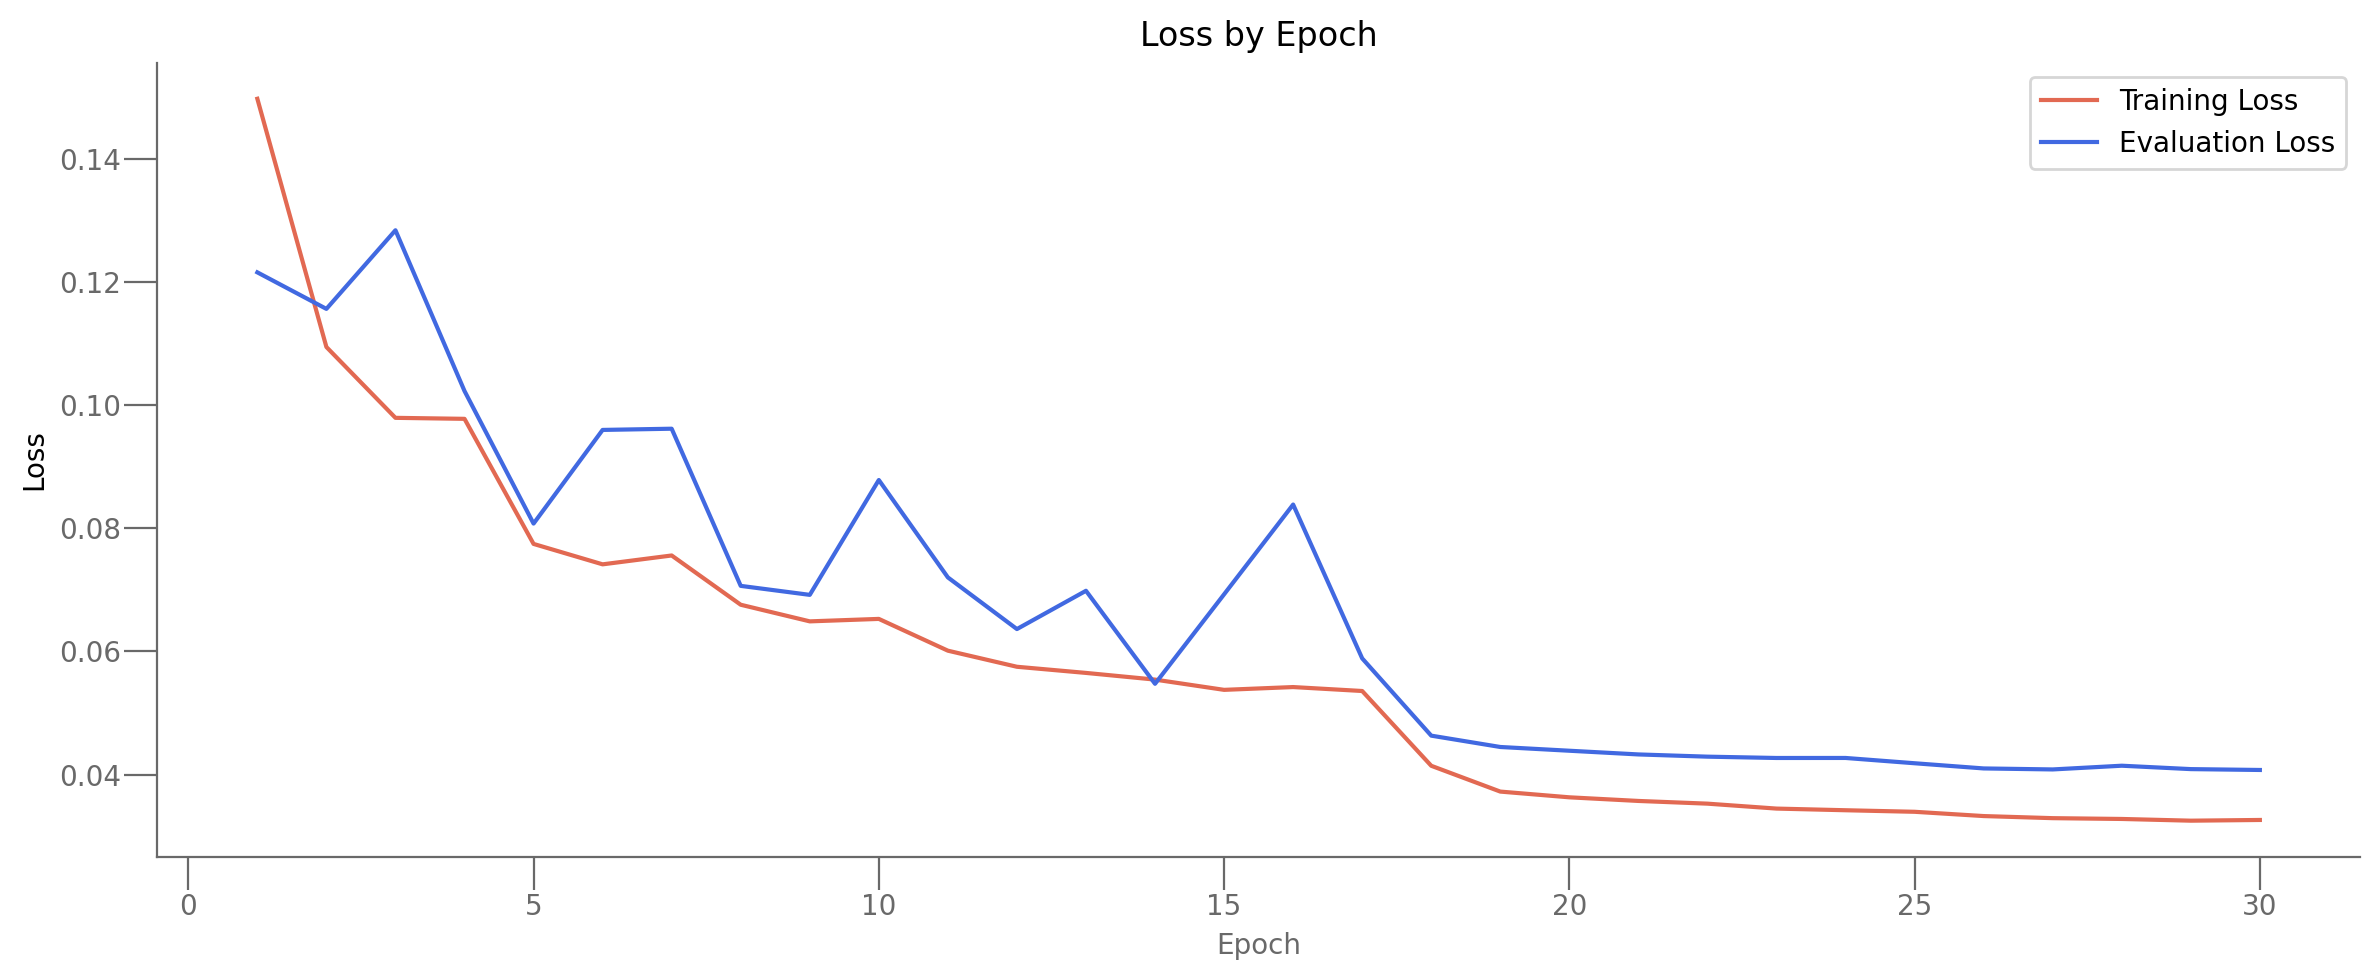


==================== TEST INFO ===================

Test_loss:-2.7460, Test_r2:0.0342


In [47]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True
        }
dataloader = trainer.train_test_val_split(dataset, **dataloader_params2)

num_early_stop = 0
num_epochs = 30
lr = 0.01
model = RecurrentGCN(n_features=n_features, n_nodes=n_nodes, embedding_dim=embedding_dim, n_target=n_target, name="RecurrentGCNInicial")
losses,eval_losses, r2scores, e, h = train(model, dataloader, num_early_stop, num_epochs, lr)
plot_training_and_eval_losses(np.array(losses).mean(axis=1), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, predictions, real = test(model, dataloader, e, h)

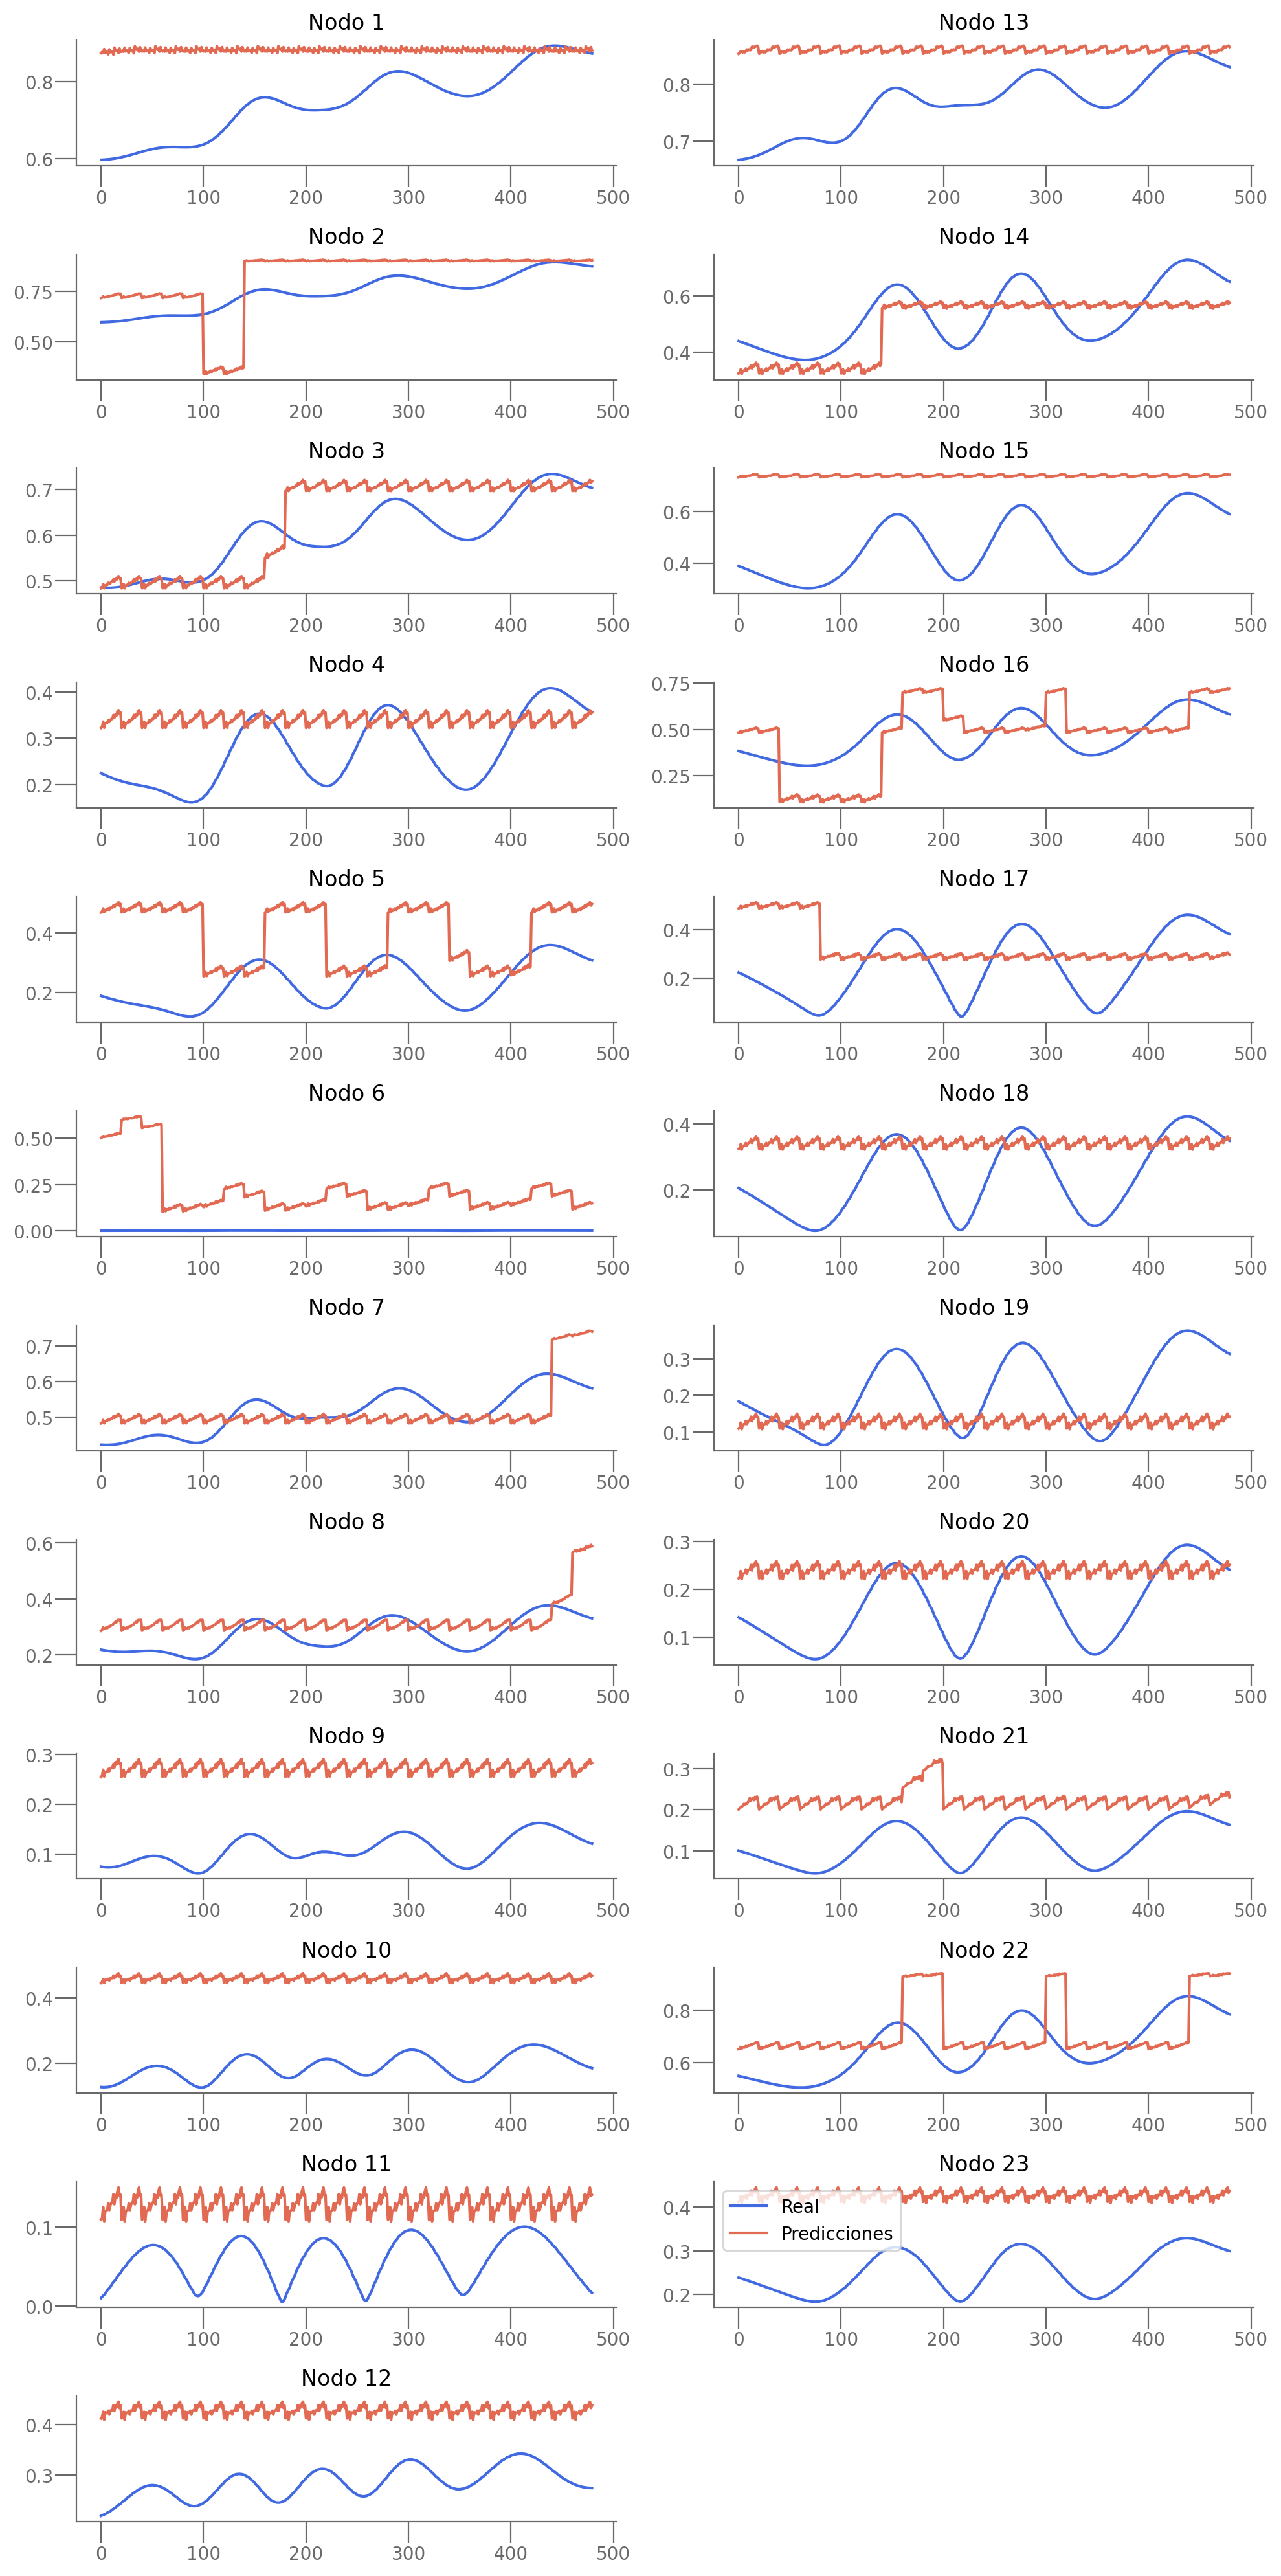

In [51]:
plot_predictions(predictions, real, n_target, 5, n_div = n_div)

#### EvolveGCN 

https://arxiv.org/abs/1902.10191

#### A3TGCN

https://arxiv.org/abs/2006.11583

In [ ]:
from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import AGCRN, TGCN, A3TGCN2
from sklearn.metrics import r2_score
from torch.optim.lr_scheduler import ReduceLROnPlateau



from utils.trainer import TrainerModel
from utils import trainer

In [ ]:
dtype = torch.float
device = torch.device("cpu")

In [ ]:
from utils import attention_temporal_gcn
from utils import temporal_gcn 
import importlib


importlib.reload(temporal_gcn)

# Reload the module to reflect the changes
importlib.reload(attention_temporal_gcn)


<module 'utils.attention_temporal_gcn' from '/home/TFM/code_dataset2/utils/attention_temporal_gcn.py'>

In [ ]:
n_nodes =dataset.features[0].shape[0]
n_target = dataset.targets[0].shape[1]
n_features_edges = dataset.edge_indices[0].shape[2]
n_time_periods_intro = dataset[0].x.shape[1]
n_edges = dataset.edge_indices[0].shape[1]
embedding_dim =32

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, batch_size, name, node_dim):
        self.name  =name
        self.batch_size = batch_size
        self.node_dim = node_dim
        super(RecurrentGCN, self).__init__()

        self.recurrent = attention_temporal_gcn.A3TGCN2(periods =node_features,
                              in_channels = 1,
                              out_channels = n_nodes,
                              batch_size = batch_size, node_dim = node_dim)
        self.linear = torch.nn.Linear(n_nodes,n_target)



    def forward(self, x, edge_index, edge_weight=None):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [ ]:
bs=20
model = RecurrentGCN(node_features = n_time_periods_intro, name = "RecurrentGCNInicial", batch_size=bs, node_dim = 1)

In [ ]:
dataloader_params2 = {
            "batch_size": bs,
            "data_split_ratio": [0.8, 0.1, 0.1],
            "seed": 42
        }
dataloader = trainer.train_test_val_split(dataset, **dataloader_params2)


Number of series in each dataset:
Train dataset: 645
Validation dataset: 75
Test dataset: 80

DataLoader information:
DataLoader for train set:
Number of batches: 32
DataLoader for val set:
Number of batches: 3
DataLoader for test set:
Number of batches: 4


In [ ]:


num_early_stop = 0
num_epochs = 30
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.to(device)
lr_schedule = ReduceLROnPlateau(
                optimizer, mode='min', factor=0.1, patience=2, min_lr=0.001)
early_stop_counter = 0
best_eval_r2score = -100.0
best_eval_loss = 0.0
losses = []


#e = torch.empty(n_nodes, embedding_dim)
#torch.nn.init.xavier_uniform_(e)
i =0
for epoch in range(num_epochs):
    model.train()
    h = None
    for batch in dataloader['train']:
        batch = batch.to(device)  
        edge_index = batch.edge_index.view(n_time_periods_intro, n_edges,len(batch),2).permute(0, 2, 3, 1)
        edge_weight = batch.edge_attr.view(n_time_periods_intro, len(batch), n_edges, n_features_edges  )[:,:,:,0]
        x = batch.x.view(len(batch),  n_nodes,n_time_periods_intro )
        y_hat = model(x, edge_index, edge_weight).view(len(batch)* n_nodes, n_target)
        y_real = batch.y
        loss = F.mse_loss(y_hat, y_real)
        loss.backward(retain_graph=True)
        losses.append(loss.item())
        optimizer.zero_grad()
        optimizer.step()
        i+=1
        #print("batch: ", i)
    train_loss =torch.FloatTensor(losses).mean().item()
    with torch.no_grad():
        model.eval()
        losses, r2scores = [], []
        for batch in dataloader['val']:
            batch = batch.to(device)  
            edge_index = batch.edge_index.view(n_time_periods_intro, n_edges,len(batch),2).permute(0, 2, 3, 1)
            edge_weight = batch.edge_attr.view(n_time_periods_intro, len(batch), n_edges, n_features_edges  )[:,:,:,0]
            x = batch.x.view(len(batch),  n_nodes,n_time_periods_intro )
            y_hat = model(x, edge_index, edge_weight).view(len(batch)* n_nodes, n_target)
            y_real = batch.y
            loss = F.mse_loss(y_hat, y_real).item()
            r2scores.append(r2_score(y_real.cpu(), y_hat.cpu()))
            losses.append(loss)
        eval_loss = torch.tensor(losses).mean().item()
        eval_r2score = np.mean(r2scores)
        
    print(f"Epoch:{epoch}, Training_loss:{train_loss:.4f}, Eval_loss:{eval_loss:.4f}, Eval_r2:{eval_r2score:.4f}, lr:{optimizer.param_groups[0]['lr']}")
    if num_early_stop > 0:
        if eval_loss <= best_eval_loss:
            best_eval_loss = eval_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
        if epoch > num_epochs / 2 and early_stop_counter > num_early_stop:
            break
        
    if lr_schedule:
        lr_schedule.step(eval_loss)

    if best_eval_r2score < eval_r2score:
        is_best = True
        best_eval_r2score = eval_r2score
    recording = {"epoch": epoch, "is_best": str(is_best)}

ValueError: Input contains NaN.

In [ ]:
model.eval()
predictions = []
real =[]
losses, r2scores = [], []
for batch in dataloader['test']:
    batch = batch.to(device)
    x = batch.x.view(len(batch), n_nodes, n_features)
    y_hat,h = model(x, e, h)
    loss = F.mse_loss(y_hat.view(-1, n_target), batch.y).item()
    preds = y_hat.view(len(batch), n_nodes, n_target)
    real.append(batch.y.view(len(batch), n_nodes, n_target).cpu())
    predictions.append(preds.cpu().detach().numpy())
    r2scores.append(r2_score(batch.y.detach().cpu(), y_hat.view(-1, n_target).detach().cpu()))
    losses.append(loss)
test_loss = torch.tensor(losses).mean().item()
test_r2score = np.mean(r2scores)

print(f"Test_loss:{test_loss:.4f}, Test_r2:{test_r2score:.4f}")


Test_loss:1.3576, Test_r2:-14.2698


In [ ]:
def reconstruir_predictions(predictions,real, n_target, situacion, n_div):
    id_situacion = situacion*n_div
    temp = np.array(predictions).reshape(-1, n_nodes, n_target)
    temp2 =np.array(real).reshape(-1, n_nodes, n_target)
    return np.concatenate([np.array(temp[id_situacion+i]) for i in range(n_div)], axis=1), np.concatenate([np.array(temp2[id_situacion+i]) for i in range(n_div)], axis=1)

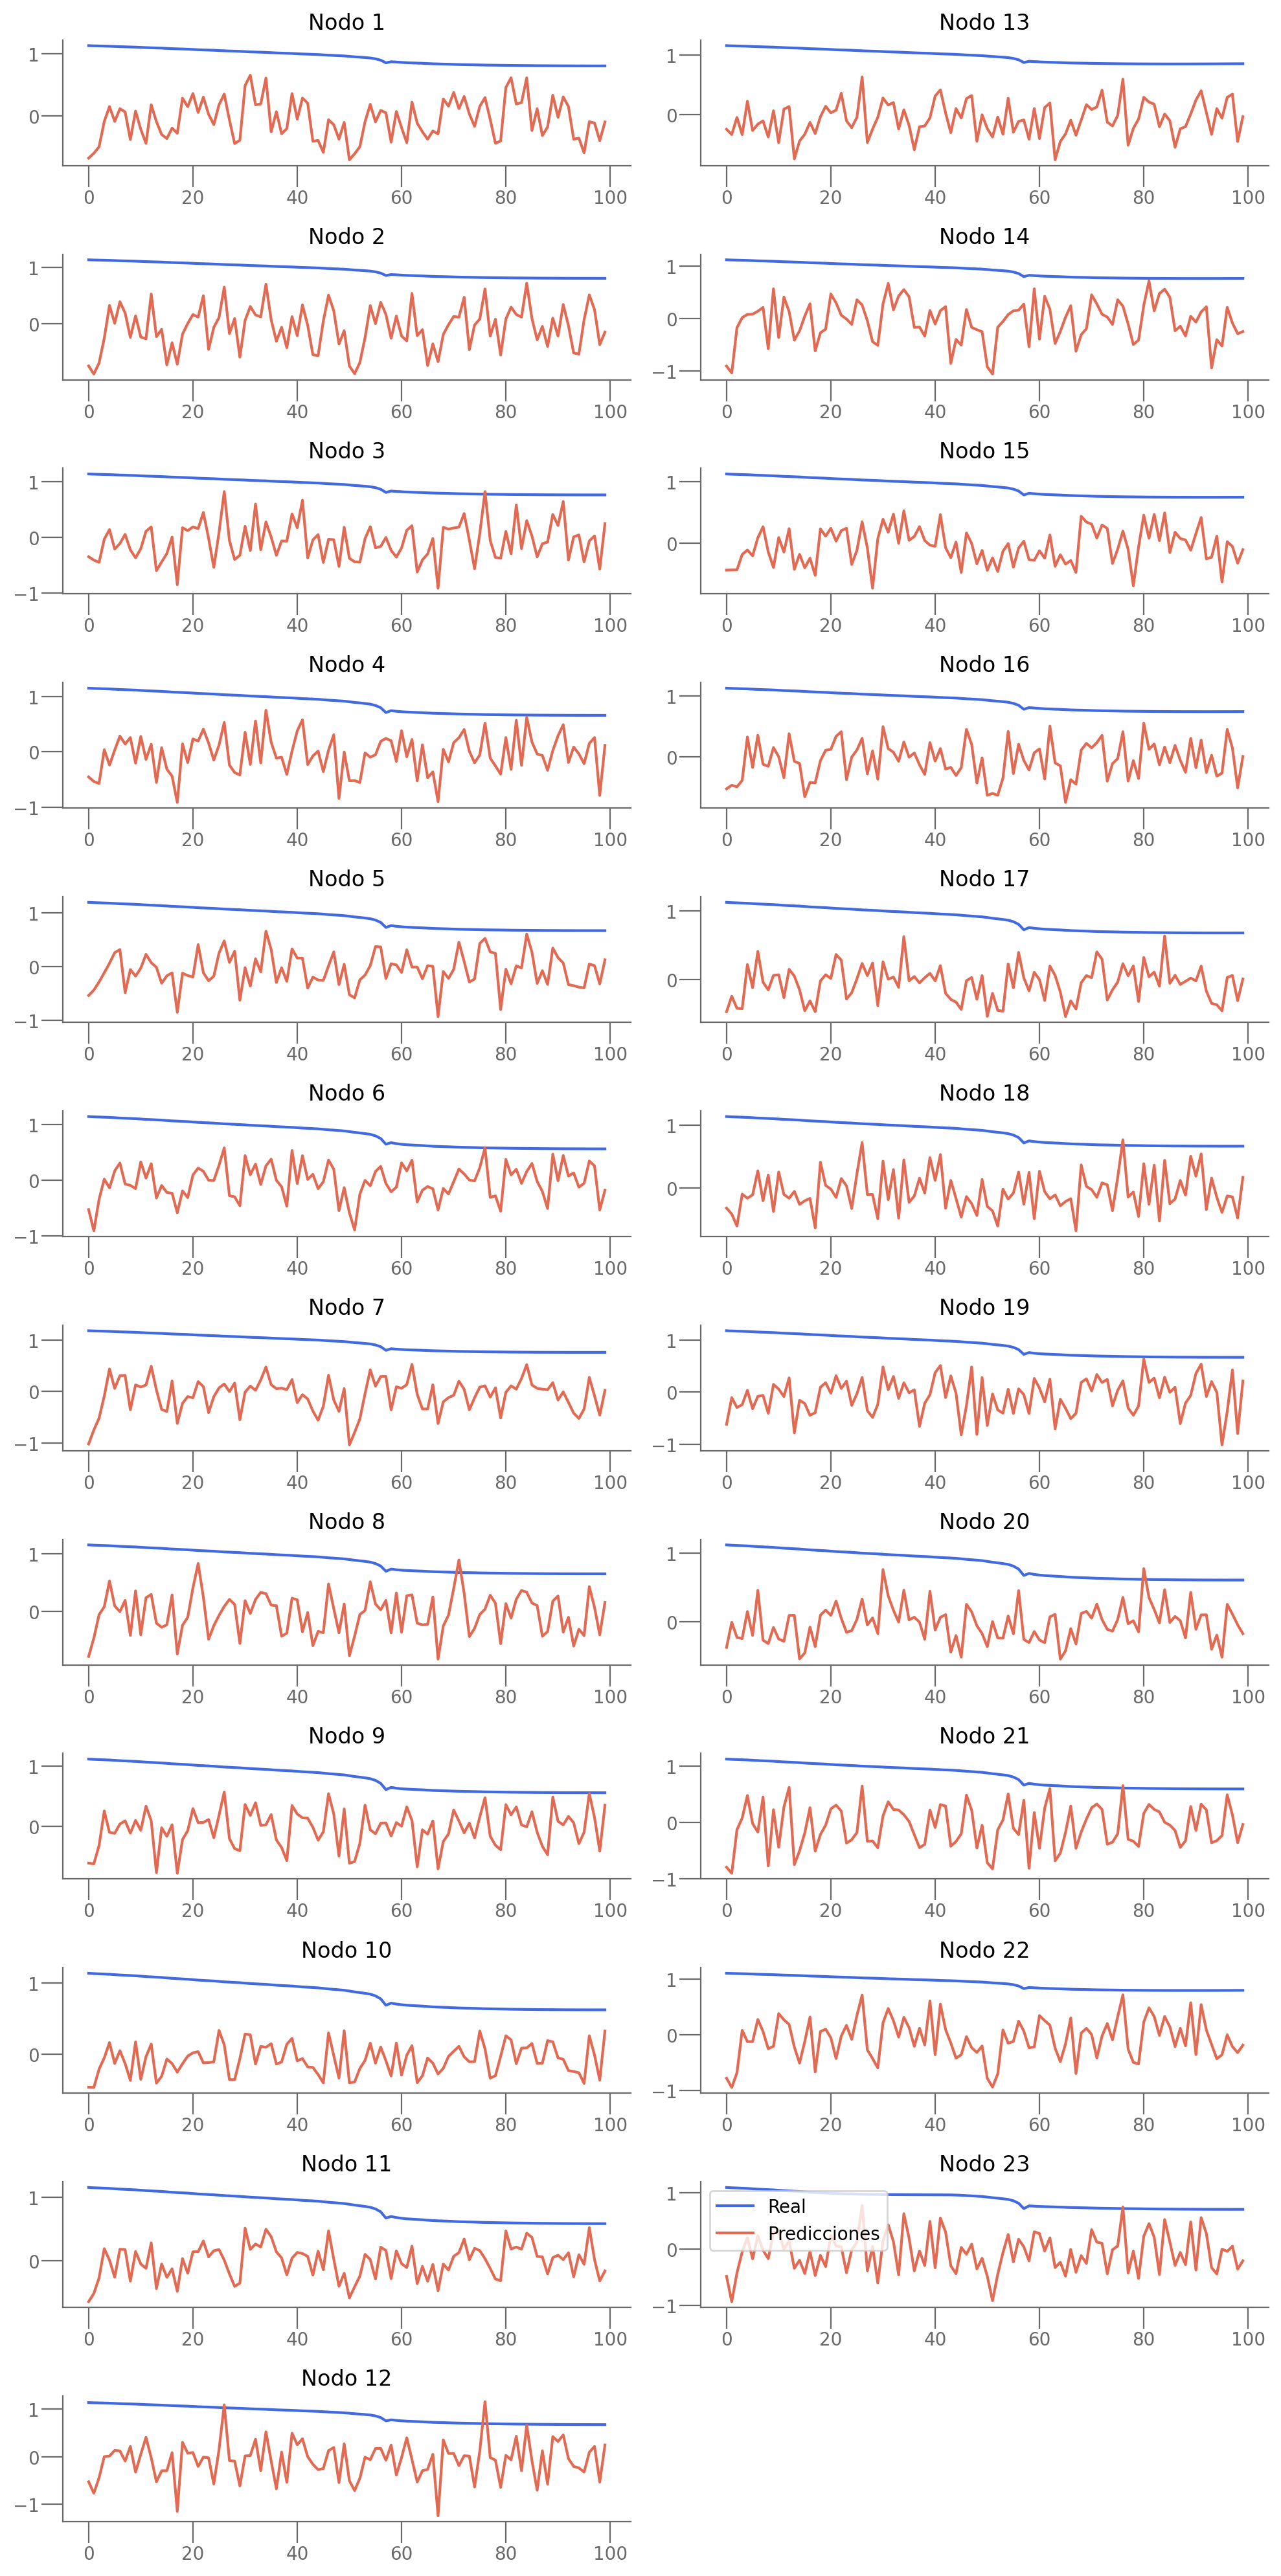

In [ ]:
n_situation = 20

n_plots = 23
n_cols = 2
n_rows = (n_plots + 1) // 2  # División redondeada hacia arriba
preds, y_true = reconstruir_predictions(predictions,real, n_target, n_situation, n_div)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 20),dpi=200)
# Trazar los gráficos
for i in range(n_plots):
    row = i % n_rows  # Calculamos el índice de la fila
    col = i // n_rows  # Calculamos el índice de la columna
    ax = axs[row, col] if n_plots > 1 else axs
    
    ax = axs[row, col] if n_plots > 1 else axs
    
    sns.lineplot(y=y_true[i],x=range(n_target*n_div), ax=ax, label='Real', legend=False, color='royalblue')
    

    sns.lineplot(y=preds[i],x=range(n_target*n_div),ax=ax, label='Predicciones', legend=False)
    
    ax.set_title(f'Nodo {i+1}')
    format_plot(ax)
    # Añadir leyenda solo al último plot
    if i == n_plots - 1:
        ax.legend(loc='upper left')

if n_plots % n_cols != 0:
    fig.delaxes(axs.flatten()[-1])
# Ajustes finales
plt.tight_layout()
plt.show()